# Analysis of the Young People Survey Dataset

The goal is to explore and analyse the data set 'Young people survey' downloaded from: https://www.kaggle.com/miroslavsabo/young-people-survey

The data contains survey responses from Slovakians between the ages of 15 - 30 and the questions are based around these areas:
Music preferences, 
Movie preferences,
Hobbies & interests,
Phobias,
Health habits,
Personality traits, views on life, & opinions,
Spending habits,
Demographics

The aim is to see how survey responses can be used to make general inferences from the responses of the survey

Written by: Jaimin Patel

1. EDA
2. Linear regression to predict age
3. Binary logistic regression to predict gender
4. Categorical logisitic regression to predict smoking/music/fears/Lie detector/ - anything
5. Support vector machine to compare prediction between logistic regression

In [1]:
# Kaggle survey data science analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
import scipy
import scipy.stats as stats
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
from IPython.display import display

Function Declarations

In [3]:
def one_hot_encode(df,cat_vars = None, num_vars = None):
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df.num_vars.apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)

In [4]:
def get_target(df, target):
    return df[target]

In [5]:
def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(df, feature_df, target_df, n_jobs = num_procs, scoring = 'neg_mean_square_error')
    mean_mse[model] = 1.0 - np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

In [6]:
def summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

In [7]:
def plot_roc(x_test, y_test, grsearch, alg_name , ax = None):

    logit_roc_auc = roc_auc_score(y_test, grsearch.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, grsearch.predict_proba(x_test)[:,1])
    
    ax = ax or plt.gca()

    ax.plot([0, 1], [0, 1],'r--')
    ax.plot(fpr, tpr)
    
    return 

In [8]:
# Polynomial Regression for R Squared calculation
def polyfit(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                      # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

In [9]:
# Function to plot a correlation plot
def plot_corr(var_x,var_y,x_name,y_name):
    
    fig, ax = plt.subplots()
    ax.plot(var_x,var_y,'o')   
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    
    z = np.polyfit(var_x, var_y, 1)
    p = np.poly1d(z)
    
    ax.plot(var_x,p(var_x),"r--")

In [10]:
# Function to plot a correlation plot average
def plot_corr_avg(var_x,var_y,x_name,y_name):
    
    min_val = int(var_x.min())
    max_val = int(var_x.max())
    
    total = np.zeros(max_val-min_val+1)
    num_entries = np.zeros(max_val-min_val+1)
    
    # Get total for the range of values
    for i in range(len(var_x)):
        total[int(var_x[i])-min_val] = total[int(var_x[i])-min_val] + var_y[i]

    for i in range(len(total)):
        num_entries[i] = sum(var_x == min_val+i)
    
    average = total/num_entries
                           
    plt.bar(list(range(min_val,max_val+1)),average) 
    plt.ylim(0,5)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    
    z = np.polyfit(var_x, var_y, 1)
    p = np.poly1d(z)
    
    plt.plot(var_x,p(var_x),"r--")

Exploratory Data Analysis to look at the raw survey data

From this we can make judgments about the data present and what analysis can be carried out


In [11]:
data = pd.read_csv(r'/Users/jaimin/Documents/Kaggle/Kaggle-young-people-survey/young-people-survey/responses.csv')

In [12]:
# Take a look at the dataset for analysis
print(data.shape)
data.head(5)

(1010, 150)


,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow


In [13]:
# Find the number of missing values
print(data.isna().sum().head(10))
print('Total number of missing values ' + str(data.isna().sum().sum()))

Music                       3
Slow songs or fast songs    2
Dance                       4
Folk                        5
Country                     5
Classical music             7
Musical                     2
Pop                         3
Rock                        6
Metal or Hardrock           3
dtype: int64
Total number of missing values 608


In [14]:
# Clean data by imputing missing data getting a median result for each category
# median used as each response is an integer value
# As there are 1010 responses imputing data rather than dropping is the preferred method
clean = data.fillna(data.median())

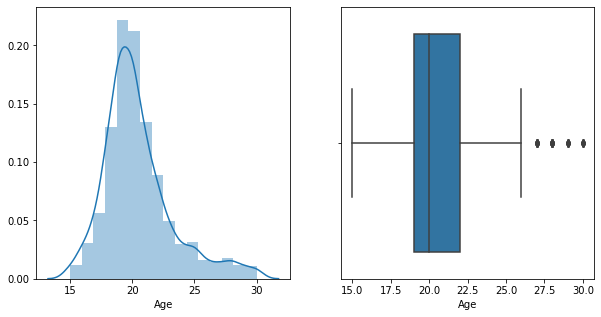

In [15]:
# Plot to show distribution of age range
plt.figure(figsize = (10 ,5))
plt.subplot(1,2,1)
sns.distplot(clean.Age, bins=16)

plt.subplot(1,2,2)
sns.boxplot(clean.Age)

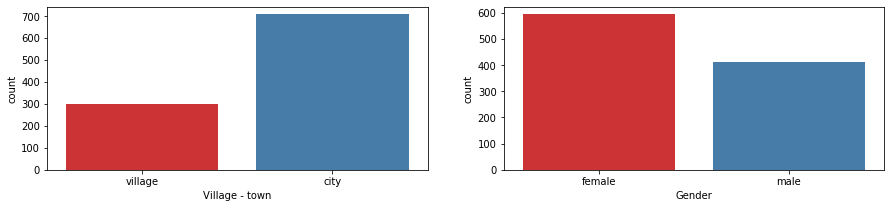

In [16]:
# Seeing the proportion of male to female respondents and whether respondents live in a village or city
plt.figure(figsize = (15,3))
plt.subplot(1,2,1)
sns.countplot(clean['Village - town'], palette = "Set1")

plt.subplot(1,2,2)
sns.countplot(clean['Gender'], palette = "Set1")

In [17]:
# Looking at weight and height of respondents
weight = clean['Weight'].mean()
height = clean['Height'].mean()

print('Mean Weight = %.2f kg' % weight)
print('Mean Height = %.2f cm' % height)

Mean Weight = 66.36 kg
Mean Height = 173.50 cm


In [18]:
# Using scipy.stats to get a measure of correlation coefficient r between weight and height

print(polyfit(clean['Weight'],clean['Weight'],1))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(clean['Weight'],clean['Height'])
print('\nR Val')
print(r_value)

{'polynomial': [1.0000000000000004, 2.5833810130324373e-15], 'determination': 1.000000000000001}

R Val
0.6747747992019404


## Investigating correlation between musical genres
Investigating the musical preferences and any correlations between music genres in a correlation heatmap

(19.5, -0.5)

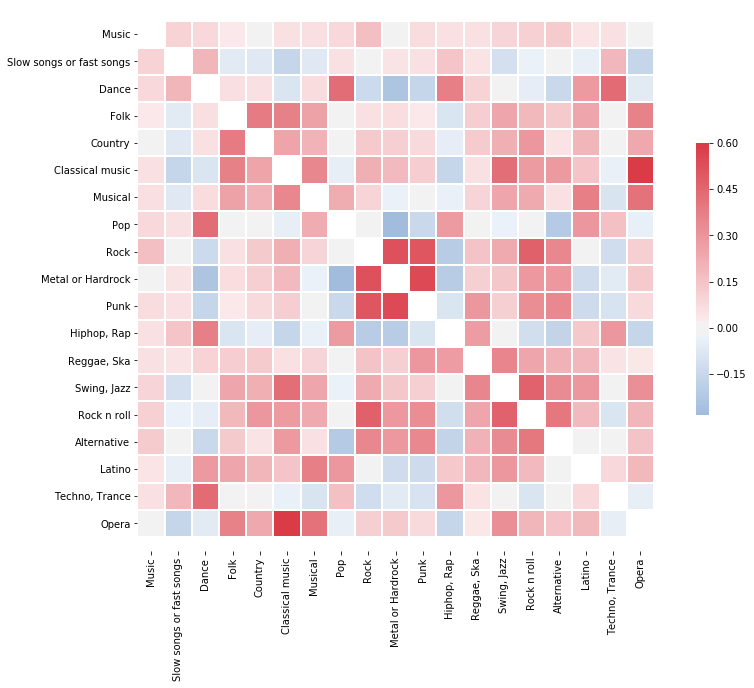

In [44]:
# Select musical categories to perform analysis on
music = ['Music','Slow songs or fast songs','Dance','Folk','Country','Classical music','Musical','Pop','Rock','Metal or Hardrock','Punk','Hiphop, Rap','Reggae, Ska','Swing, Jazz','Rock n roll','Alternative','Latino','Techno, Trance','Opera']
corr = clean[music].corr()
mask = np.zeros_like(corr, dtype=np.bool)
np.fill_diagonal(mask, True)
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.6,center=0,square=True,linewidths=1,cbar_kws={"shrink": .5})
ax.set_ylim(len(music)+0.5, -0.5)

Plotting a heatmap for all music genres in dataset, we can see that there is a range of correlation between genres. Positive correlation between genres is far stronger than negative correlation. 

It is interesting to see that the 'Metal or Hardrock' category has a more polar view of music where the respondents are likely to correlate strongly or negatively with other genres of music as it has some of the darkesrred shades and darker blue shades. 

Another interesting category to analyse is the 'Hiphop, Rap' group which is more likely to correlate negatively with other genres indicated by the amount of blue in this row/column compared with other genres. The listeners of Hiphop and Rap are less likely to listten to other genres of music.

For example, Rock, Metal or Hardrock and Punk are very strongly correlated with each other as is Classical Music and Opera. On the other hand, Metal or Hardrock and Pop are negatively correlated.

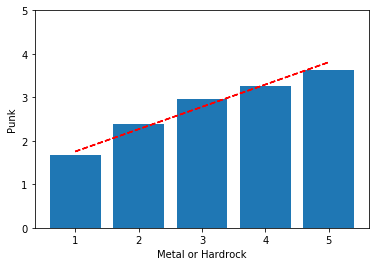

In [26]:
var_x = 'Metal or Hardrock'
var_y = 'Punk'
plot_corr_avg(clean[var_x],clean[var_y],var_x,var_y)

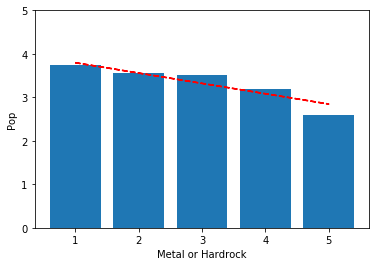

In [28]:
var_x = 'Metal or Hardrock'
var_y = 'Pop'
plot_corr_avg(clean[var_x],clean[var_y],var_x,var_y)

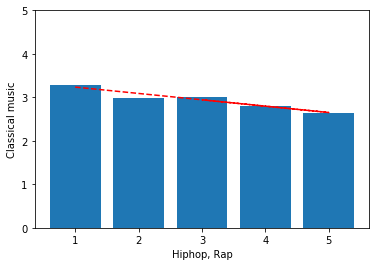

In [25]:
var_x = 'Hiphop, Rap'
var_y = 'Classical music'
plot_corr_avg(clean[var_x],clean[var_y],var_x,var_y)


Making inferences using the correlation plot something against age

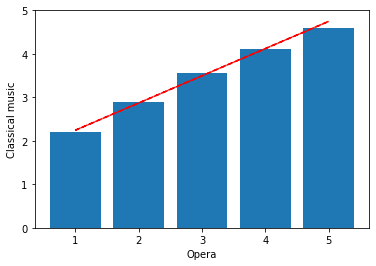

In [29]:
var_x = 'Opera'
var_y = 'Classical music'
plot_corr_avg(clean[var_x],clean[var_y],var_x,var_y)

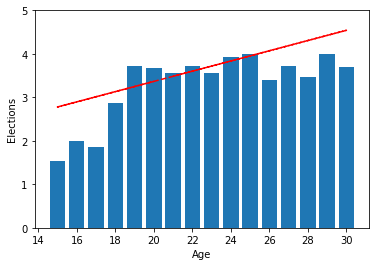

In [72]:
var_x = 'Age'
var_y = 'Elections'
plot_corr_avg(clean[var_x],clean[var_y],var_x,var_y)

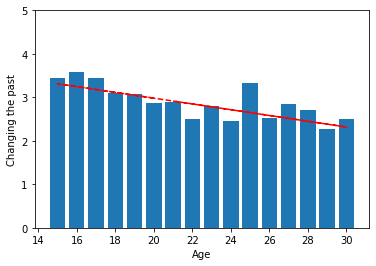

In [31]:
var_x = 'Age'
var_y = 'Changing the past'
plot_corr_avg(clean[var_x],clean[var_y],var_x,var_y)

Looking at the EDA, the respondents are a range of ages from 15 to 30, most are around 20 years old who are city dwellers and female. They have a range of musical preferences showing trends in similar genres.

For machine learning we standardise variables and ensure regularisation to dataset

In [20]:
# Data categorised either by numeric or categorical values

features_numeric = [col for col in data.columns if data[col].dtype != 'object']
features_categories = [col for col in data.columns if data[col].dtype == 'object']

In [21]:
# Trying Linear Regression to Predict age
# Divide dataset into male and female data and include only numeric feaures

male_df = clean[clean["Gender"] == "male"]
female_df = clean[clean["Gender"] == "female"]

male_numeric = male_df[["Height","Weight","Age"]]
female_numeric = female_df[features_numeric]

# Store HEIGHT in each dataframe and drop it from the main one
male_height = male_numeric['Age']
female_height = female_numeric['Age']

male_numeric.drop("Age", axis=1, inplace = True)
female_numeric.drop("Age", axis=1, inplace = True)

# Do a test train split
X_train_m , X_test_m, y_train_m, y_test_m = train_test_split(male_numeric, male_height, test_size=0.2, random_state=0)
X_train_f , X_test_f, y_train_f, y_test_f = train_test_split(female_numeric, female_height, test_size=0.2, random_state=0)

regressor_m = LinearRegression()
regressor_f = LinearRegression()
regressor_m.fit(X_train_m, y_train_m)
regressor_f.fit(X_train_f, y_train_f)

y_pred_m = regressor_m.predict(X_test_m)
y_pred_f = regressor_f.predict(X_test_f)

df_m = pd.DataFrame({'Actual': y_test_m, 'Predicted': y_pred_m})
print('Male Actual and Predicted\n')
print(df_m.head(10))

print("\nFemale Actual and Predicted\n")
df_f = pd.DataFrame({'Actual': y_test_f, 'Predicted': y_pred_f})
print(df_f.head(10))

print('\nMale Prediciton Statistics')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_m, y_pred_m))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_m, y_pred_m))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_m, y_pred_m)))

print('\nFemale Prediction Statistics')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_f, y_pred_f))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_f, y_pred_f))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_f, y_pred_f)))

Male Actual and Predicted

     Actual  Predicted
762    24.0  21.017943
181    23.0  21.396442
835    19.0  20.195998
872    20.0  20.519346
768    26.0  22.234622
383    22.0  22.029136
218    18.0  20.211117
37     21.0  23.159310
776    25.0  20.494433
821    17.0  22.953824

Female Actual and Predicted

     Actual  Predicted
391    24.0  20.358650
232    19.0  17.892050
973    20.0  20.764532
145    19.0  23.848306
276    21.0  16.078404
737    21.0  20.621811
975    23.0  22.380414
781    20.0  23.254845
304    18.0  18.030993
376    20.0  20.853257

Male Prediciton Statistics
Mean Absolute Error: 1.8955574824292156
Mean Squared Error: 5.787435352542096
Root Mean Squared Error: 2.4057089085219965

Female Prediction Statistics
Mean Absolute Error: 2.052905656331096
Mean Squared Error: 6.935883261589224
Root Mean Squared Error: 2.633606512292454


In [22]:
clean.describe(include = np.number)

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,...,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.00000
mean,4.732673,3.327723,3.112871,2.287129,2.122772,2.956436,2.762376,3.473267,3.763366,2.360396,...,3.233663,3.050495,3.200990,3.105941,2.870297,3.558416,20.430693,173.503960,66.357426,1.29604
std,0.663222,0.833232,1.168268,1.136271,1.073501,1.248223,1.259639,1.160029,1.181474,1.371093,...,1.321791,1.305028,1.187229,1.203589,1.284970,1.092842,2.819240,9.924916,13.705814,1.01059
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,62.000000,41.000000,0.00000
25%,5.000000,3.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,19.000000,167.000000,56.000000,1.00000
50%,5.000000,3.000000,3.000000,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,2.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,20.000000,173.000000,64.000000,1.00000
75%,5.000000,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,5.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,22.000000,180.000000,75.000000,2.00000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,30.000000,203.000000,165.000000,10.00000


In [23]:
# Looking at the non-numerical data in the dataframe
clean.describe(include = ['O'])

,Smoking,Alcohol,Punctuality,Lying,Internet usage,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
count,1002,1005,1008,1008,1010,1004,1007,1009,1008,1006,1006
unique,4,3,3,4,4,2,2,6,2,2,2
top,tried smoking,social drinker,i am always on time,sometimes,few hours a day,female,right handed,secondary school,no,city,block of flats
freq,430,659,399,549,744,593,906,621,754,707,595


Drop outliers for height by using a Z score measure of more than 3 Std. deviations from the mean of the data

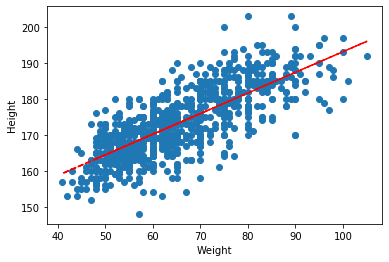

In [24]:
z = np.abs(stats.zscore(clean[features_numeric]))
height_df = clean[(z < 3).all(axis=1)]
plot_corr(height_df.Weight,height_df.Height,'Weight','Height')

Now we look at the correlations between variables for music

# Logistic regression to classify gender

Now we perform analysis to see what we can infer from the survey using machine learning models

From the responses of the survey we predict gender from Binary logistic regression and tune parameters to get the highest accuracy using gridsearch CV.

Then the same analysis is carried out using SVM again with gridsearch CV.

In [32]:
# Prepare data for gender classification
# Assign a variable for binary classification
y_variable = "Gender"

category_map = {y_variable:{'male': 0, 'female': 1}}
# category_map = {y_variable:{'city': 0,'village':1}}

ml_inputs = clean.dropna()
ml_y = ml_inputs[y_variable]

ml_inputs.drop(columns=y_variable, inplace = True)
ml_x = ml_inputs[features_numeric] # X logisitc and using numeric feature data

# FIGURE OUT HOW TO INCLUDE CATEGORICAL DATA
for key,val in category_map[y_variable].items():
    ml_y.replace(key, val, inplace = True)

In [33]:
# LOGISTIC REGRESSION FOR BINARY CLASSIFICATION OF GENDER
# Initially using a split of 80-20% training-test data try with (clean)
log_x_train, log_x_test, log_y_train, log_y_test = train_test_split(ml_x, ml_y, test_size=0.2)

# Feature normalisation
scaler = StandardScaler()
scaler.fit(log_x_train)
log_x_train = scaler.transform(log_x_train)
log_x_test = scaler.transform(log_x_test)

# LOGISTIC REGRESSION
logistic_regression = LogisticRegression()
logistic_regression.fit(log_x_train,log_y_train)

# IMPLEMENT KFOLD CROSS VALIDATION
# Using KFold cross validation with gridserachcv
Kfolds = KFold(n_splits = 10)
parameter_grid = {'C':[.001, 0.01, .03, .1, 0.3, 1, 3, 10]}
log_grsearch = GridSearchCV(logistic_regression, param_grid=parameter_grid, cv=Kfolds, scoring='f1')
log_grsearch.fit(log_x_train, log_y_train)

print(log_grsearch.best_params_)
log_y_score = log_grsearch.predict(log_x_test)

{'C': 0.03}


# Using SVM to classify gender

This is for a comparison to Logistic regression for accuracy


In [34]:
# Using the support vector machine algorithm for classification
# svc = svm.SVC(kernel = 'linear',probability=True)
svc = svm.SVC(gamma = 'scale', decision_function_shape='ovo',probability=True)

# Initially using a split of 80-20% training-test data try with (clean)
svm_x_train, svm_x_test, svm_y_train, svm_y_test = train_test_split(ml_x, ml_y, test_size=0.2)

# Feature normalisation
scaler_svm = StandardScaler()
scaler_svm.fit(svm_x_train)
svm_x_train = scaler_svm.transform(svm_x_train)
svm_x_test = scaler_svm.transform(svm_x_test)

# Using KFold cross validation with SVM
Kfolds = KFold(n_splits=10)
parameter_grid = {'C':[.001,0.01,.03,.1,0.3,1,3,10]}
svm_grsearch = GridSearchCV(svc, param_grid=parameter_grid, cv=Kfolds, scoring = 'f1')
svm_grsearch.fit(svm_x_train, svm_y_train)

print(svm_grsearch.best_params_)
svm_y_score = svm_grsearch.predict(svm_x_test)

{'C': 3}


## Results of Logistic Regression and SVM
Show results of logistic regression and SVM

Logistic regression accuracy: 0.9528301886792453
Average precision-recall score: 0.93
[[ 85   5]
 [  5 101]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        90
           1       0.95      0.95      0.95       106

    accuracy                           0.95       196
   macro avg       0.95      0.95      0.95       196
weighted avg       0.95      0.95      0.95       196


SVM accuracy: 0.9439252336448598
Average precision-recall score: 0.93
[[ 83   5]
 [  7 101]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        88
           1       0.95      0.94      0.94       108

    accuracy                           0.94       196
   macro avg       0.94      0.94      0.94       196
weighted avg       0.94      0.94      0.94       196



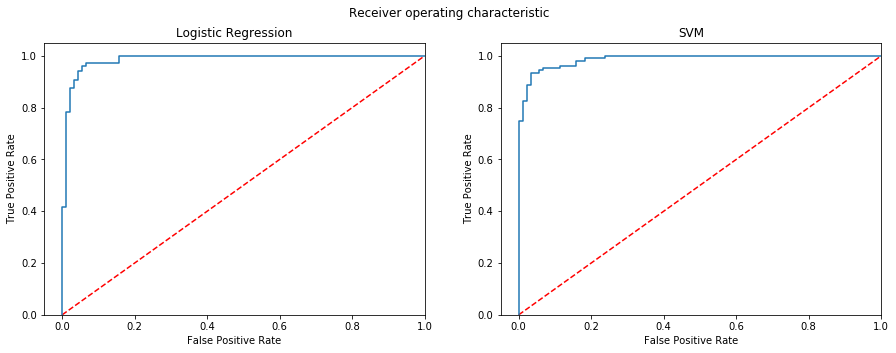

In [37]:
# INTERPERET RESULTS and apply function for ROC curve

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

ax1.set_xlim([-0.05, 1.0])
ax2.set_xlim([-0.05, 1.0])
ax1.set_ylim([0.0, 1.05])
ax2.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax2.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax2.set_ylabel('True Positive Rate')
fig.suptitle('Receiver operating characteristic')

plt.savefig('Log_ROC')

plot_roc(log_x_test, log_y_test, log_grsearch, 'Logistic Regression', ax1)
plot_roc(svm_x_test, svm_y_test, svm_grsearch, 'SVM', ax2)

ax1.set_title('Comparing ROC curves for Logisitic regression and SVM')
ax1.set_title('Logistic Regression')
ax2.set_title('SVM')

print("Logistic regression accuracy:", log_grsearch.score(log_x_test, log_y_test))

average_precision = average_precision_score(log_y_test, log_y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

conf_matrix = confusion_matrix(log_y_test, log_y_score)
print(conf_matrix)
print(classification_report(log_y_test, log_y_score))

# Metrics
print("\nSVM accuracy:", svm_grsearch.score(svm_x_test, svm_y_test))

average_precision = average_precision_score(svm_y_test, svm_y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

conf_matrix = confusion_matrix(svm_y_test, svm_y_score)
print(conf_matrix)
print(classification_report(svm_y_test, svm_y_score))

plt.show()

We see that both Logistic Regression and SVM are accurate ways to classify gender from the survey responses. The ~96% accurate for logistic regression is comparable to that of SVM both using gridsearchcv sklearn method.

Analysing the ROC curves: They both hug the y-axis and have a flat top, showing that the prediction of gender is accurate from the responses of the survey

# Multiclass Logistic Regression

Using "Internet usage" as the multiclass logistic regression classification variable. This is grouped into categoires: "few hours a day", "most of the day", "less than an hour a day"

In [38]:
# Two variables, one for logistic regression
# y_logistic = "Alcohol"
y_logistic = "Internet usage"

ml_inputs = clean.dropna()
ml_y = ml_inputs[y_logistic]

ml_inputs.drop(columns=y_logistic, inplace = True)
ml_x = ml_inputs
# ml_x = ml_inputs[features_numeric] # X logisitc and using numeric feature data

# # FIGURE OUT HOW TO INCLUDE CATEGORICAL DATA
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown = 'ignore')

# Initially using a split of 80-20% training-test data try with (clean)
x_train, x_test, y_train, y_test = train_test_split(ml_x, ml_y, test_size=0.2)

encoder.fit(x_train)
x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

logistic_regression_multi = LogisticRegression(solver='lbfgs',multi_class = 'multinomial') # Multiclass
logistic_regression_multi.fit(x_train,y_train)

y_score_multi = logistic_regression_multi.predict(x_test)

# Using KFold cross validation
# Kfolds = KFold(n_splits=10)

# print("Logistic regression accuracy :", logm_grsearch.score(x_test, y_test))
print("Logistic regression accuracy :", logistic_regression_multi.score(x_test, y_test))

# print(y_score_multi, y_test)

Logistic regression accuracy : 0.6683673469387755


In [39]:
y_score_df = pd.Series(y_score_multi)

y_1 = y_test.value_counts().to_frame()
print(y_1)
print(y_score_df.value_counts())

                         Internet usage
few hours a day                     140
most of the day                      30
less than an hour a day              25
no time at all                        1
few hours a day            159
most of the day             20
less than an hour a day     17
dtype: int64


ValueError: shape mismatch: objects cannot be broadcast to a single shape

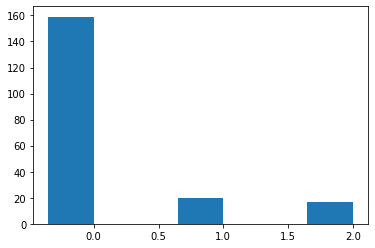

In [40]:
# fig, axes = plt.subplots(1, 2, figsize = (10,10)) https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
fig, ax = plt.subplots()

labels = ['no time at all', 'less than an hour a day', 'few hours a day', 'most of the day']
x = np.arange(len(labels)-1)
width = 0.35

y_score_vals = y_score_df.value_counts().to_frame()
y_score_vals.columns = ["Internet usage"]
y_test_vals = y_test.value_counts().to_frame()

# prediction = ax.bar(y_score_vals.index, y_score_vals["Internet usage"], width, label = "Prediction")
prediction = ax.bar(x - 0.5 *width, y_score_vals["Internet usage"], width, label = "Prediction", align = "center")
test = ax.bar(x + 0.5* width, y_test_vals["Internet usage"], width, label = "Test", align = "center")

ax.set_xticks(x)
ax.set_xticklabels(labels[:3])

print(y_score_vals)
print(y_test_vals)

plt.show()

Applying logistic regression for multiclass classification for how much a person uses internet per day reasonably accurate, 60-70% of the time predicting correctly